In [52]:
import numpy as np
import pandas as pd
from joblib import dump, load
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import scipy

In [102]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
clf = load('data/model_combined.joblib')
clf_b = load('data/model_baseline.joblib')
clf_v = load('data/model_vitals.joblib')

In [3]:
data_dir = './data/'
with np.load('data/Xy.npz') as f:
    X = f['X']
    y = f['y']

pop = pd.read_csv(data_dir + 'population/d10_with_vitals.csv').set_index('BMT_ID')

split_date = 201701001
split_idx = -85

Xtr, Xte = X[:split_idx], X[split_idx:]
ytr, yte = y[:split_idx], y[split_idx:]

In [19]:
print('Held-out test set, N={}'.format(len(yte)))

Held-out test set, N=85


## Hypothesis testing

In [107]:
auc_main, auc_scores_main, fpr_main, tpr_main = evaluate_model(clf, Xte, yte, Xtr, 55, verbose=False)
auc_base, auc_scores_base, fpr_base, tpr_base = evaluate_model(clf_b, Xte[:, :52], yte, Xtr[:, :52], 55, verbose=False)
auc_v, auc_scores_v, fpr_v, tpr_v = evaluate_model(clf_v, Xte[:, 52:], yte, Xtr[:, 52:], 55, verbose=False)

In [108]:
# H0: proposed = baseline
# H1: proposed > baseline
(np.array(auc_scores_main) <= np.array(auc_scores_base)).mean()

0.018

In [109]:
# H0: proposed = vitals-only
# H1: proposed > vitals-only
(np.array(auc_scores_main) <= np.array(auc_scores_v)).mean()

0.164

## Confusion matrix

In [37]:
from sklearn import metrics, utils

def boostrap_func_all(i, y_true, y_prob, threshold):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    y_true_b, y_prob_b = utils.resample(y_true, y_prob, replace=True, random_state=i)
    y_pred_b = (y_prob_b > threshold)
    tpr_cutoff = metrics.recall_score(y_true_b, y_pred_b)
    idx = (np.abs(tpr - tpr_cutoff)).argmin()
    
    return (
        metrics.roc_auc_score(y_true_b, y_prob_b), # AUC
        tpr[idx], # sensitivity
        1-fpr[idx], # specificity
        metrics.precision_score(y_true_b, y_pred_b), # positive predictive value
    )

def boostrap_func_confusion(i, y_true, y_prob, threshold):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)
    y_true_b, y_prob_b = utils.resample(y_true, y_prob, replace=True, random_state=i)
    y_pred_b = (y_prob_b > threshold)
    tpr_cutoff = metrics.recall_score(y_true_b, y_pred_b)
    idx = (np.abs(tpr - tpr_cutoff)).argmin()
    
    return metrics.confusion_matrix(y_true_b, y_pred_b).ravel()

def evaluate_model(clf, Xte, yte, Xtr=None, threshold_p=55, verbose=True):
    y_true = yte
    y_score = clf.decision_function(Xte)
    y_prob = clf.predict_proba(Xte)[:,1]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    test_auc = metrics.roc_auc_score(y_true, y_score)
    
    # Picking a risk threshold based on training set if possible
    if Xtr is not None:
        if verbose: print('Risk threshold based on train set')
        threshold = np.percentile(clf.predict_proba(Xtr)[:,1], threshold_p)
    else:
        if verbose: print('Risk threshold based on test set')
        threshold = np.percentile(y_score, threshold_p)
    if verbose: print('p_Threshold', threshold)
    
    if verbose: print()
    if verbose: print('Confusion matrix (95%CI lower, upper), [TN, FP, FN, TP]')
    y_pred = (y_prob > threshold)
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    if verbose: print(conf_mat) # Rows: actual 0, actual 1; Cols: predicted 0, predicted 1
    
    confmats = [boostrap_func_confusion(i, y_true, y_prob, threshold) for i in range(1000)]
    confmats_ = np.asarray(confmats)
    if verbose: print(np.percentile(confmats_, 2.5, axis=0).reshape(2,2))
    if verbose: print(np.percentile(confmats_, 97.5, axis=0).reshape(2,2))

    if verbose: print()
    if verbose: print('scores (95%CI lower, upper)')
    auc_scores, sensitivities, specificities, ppvs = zip(*[boostrap_func_all(i, y_true, y_prob, threshold) for i in range(1000)])
    if verbose: print('Test AUC {:.3f} ({:.3f}, {:.3f})'.format(np.mean(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
    if verbose: print('sens.\t {:.1%} ({:.1%}, {:.1%})'.format(np.mean(sensitivities), np.percentile(sensitivities, 2.5), np.percentile(sensitivities, 97.5)))
    if verbose: print('spec.\t {:.1%} ({:.1%}, {:.1%})'.format(np.mean(specificities), np.percentile(specificities, 2.5), np.percentile(specificities, 97.5)))
    if verbose: print('prec.\t {:.1%} ({:.1%}, {:.1%})'.format(np.mean(ppvs), np.percentile(ppvs, 2.5), np.percentile(ppvs, 97.5)))
    
    return test_auc, auc_scores, fpr, tpr

In [38]:
auc_main, auc_scores_main, fpr_main, tpr_main = evaluate_model(clf, Xte, yte, Xtr, 55)

Risk threshold based on train set
p_Threshold 0.4500170479814553

Confusion matrix (95%CI lower, upper), [TN, FP, FN, TP]
[[29 27]
 [11 18]]
[[20. 19.]
 [ 5. 11.]]
[[37. 36.]
 [17. 26.]]

scores (95%CI lower, upper)
Test AUC 0.659 (0.536, 0.784)
sens.	 62.1% (44.8%, 82.8%)
spec.	 59.1% (42.9%, 80.4%)
prec.	 39.9% (25.6%, 55.1%)


## High-risk patients

In [11]:
TPs = list(np.argwhere((y_true == y_pred) & (y_true == 1)).ravel())

In [12]:
len(TPs)

18

In [13]:
TPs

[0, 5, 6, 10, 15, 16, 20, 30, 37, 39, 46, 50, 54, 58, 65, 79, 82, 84]

In [13]:
TPs_id = pop[split_idx:].iloc[TPs]
labels = pd.read_csv(data_dir + 'prep/label.csv').set_index('BMT_ID')
before_onset = labels.loc[TPs_id.index][['GVHD_onset_day', 'GVHD_max_day']].min(axis=1)

In [18]:
labels.loc[TPs_id.index]

,Label_GVHD,Label_relapse,Label_survival_d180,GVHD_onset_grade,GVHD_onset_day,GVHD_max_grade,GVHD_max_day,death_day
BMT_ID,,,,,,,,
201701001,1,1,0,NaN,18.0,2,42.0,NaN
201702001,1,1,0,NaN,18.0,2,18.0,NaN
201702002,1,1,0,NaN,37.0,3,37.0,422.0
201702006,1,1,0,NaN,32.0,2,27.0,233.0
201704002,1,1,0,NaN,27.0,2,27.0,129.0
201704003,1,1,0,NaN,20.0,2,20.0,80.0
201704007,1,1,0,NaN,16.0,2,56.0,NaN
201705007,1,1,0,NaN,92.0,2,98.0,NaN
201706006,1,1,0,NaN,38.0,2,38.0,NaN


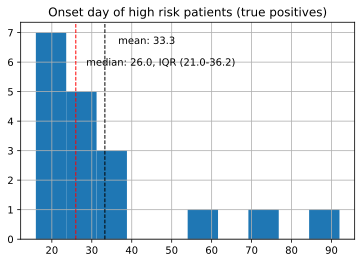

In [105]:
x = before_onset
x.hist()
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(x.median(), color='r', linestyle='dashed', linewidth=1)
_, max_ = plt.ylim()
plt.text(x.mean() + x.mean()/10,  max_ - max_/10, 'mean: {:.1f}'.format(x.mean()))
plt.text(x.median() + x.median()/10,  max_ - 2*max_/10, 'median: {:.1f}, IQR ({:.1f}-{:.1f})'.format(
    x.median(), *np.percentile(x, [25, 75])
))
plt.title('Onset day of high risk patients (true positives)')
plt.show()

In [43]:
tmp = labels.loc[pop[split_idx:].index]
print('Onset of positive cases occurred after transplant within median {} (IQR={:.1f}-{}) days'.format(
    tmp[tmp['Label_GVHD'] == 1]['GVHD_onset_day'].median(), 
    *np.percentile(tmp[tmp['Label_GVHD'] == 1]['GVHD_onset_day'], [25,75])
))

Onset of positive cases occurred after transplant within median 36.0 (IQR=24.0-69.0) days


## ROC curves

In [49]:
def boostrap_func(i, y_true, y_score):
    yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
    return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)

def get_roc_CI(y_true, y_score):
    roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(boostrap_func)(i, y_true, y_score) for i in tqdm(range(1000), leave=False)))

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for fpr, tpr, _ in roc_curves:
        tprs.append(scipy.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(metrics.auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 1.0 * std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 1.0 * std_tpr, 0)
    return roc_curves, auc_scores, mean_fpr, mean_tpr, tprs_lower, tprs_upper

In [59]:
auc_base, auc_scores_base, fpr_base, tpr_base = evaluate_model(clf_b, Xte[:, :52], yte, Xtr[:, :52], 55, verbose=False)
auc_v, auc_scores_v, fpr_v, tpr_v = evaluate_model(clf_v, Xte[:, 52:], yte, Xtr[:, 52:], 55, verbose=False)

In [62]:
results_main = (
    auc_main, auc_scores_main, fpr_main, tpr_main,
    *get_roc_CI(yte, clf.predict_proba(Xte)[:,1]),
)
results_baseline = (
    auc_base, auc_scores_base, fpr_base, tpr_base, 
    *get_roc_CI(yte, clf_b.predict_proba(Xte[:, :52])[:,1]),
)
results_vitals = (
    auc_v, auc_scores_v, fpr_v, tpr_v,
    *get_roc_CI(yte, clf_v.predict_proba(Xte[:, 52:])[:,1]),
)


 95%|█████████▌| 952/1000 [00:00<00:00, 1864.13it/s]
                                                    
 97%|█████████▋| 968/1000 [00:00<00:00, 3068.99it/s]
                                                    
 92%|█████████▏| 920/1000 [00:00<00:00, 2694.82it/s]
                                                    

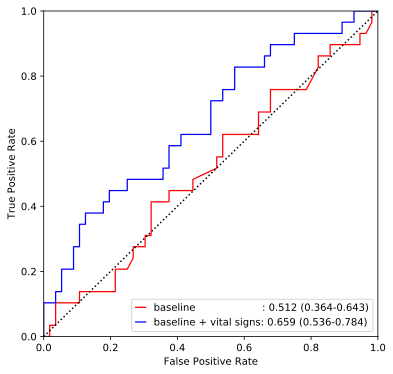

In [104]:
fig, ax = plt.subplots(figsize=(6,6))
for name, output, color in [
    (r'baseline                     ', results_baseline, 'red'), 
    (r'baseline + vital signs', results_main, 'blue')
]:
    _, _, fpr, tpr, roc_curves, auc_scores, mean_fpr, mean_tpr, tprs_lower, tprs_upper = output
    auc_scores = np.array(auc_scores)
    idx_lower = abs(auc_scores - np.percentile(auc_scores, 2.5)).argmin()
    idx_upper = abs(auc_scores - np.percentile(auc_scores, 97.5)).argmin()
    lower = scipy.interp(mean_fpr, roc_curves[idx_lower][0], roc_curves[idx_lower][1])
    upper = scipy.interp(mean_fpr, roc_curves[idx_upper][0], roc_curves[idx_upper][1])
    
    plt.plot(
        fpr, tpr, color=color, lw=1.25, 
        label='{}: {:.3f} ({:.3f}-{:.3f})'.format(
            name, metrics.auc(fpr, tpr),
            np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5),
        )
    )

plt.legend(loc='lower right', handlelength=1)
plt.plot([0,1], [0,1], 'k:')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1)
plt.ylim(0,1)

# plt.title('task')
plt.savefig('fig/ROC_curves.pdf', bbox_inches='tight')
plt.show()

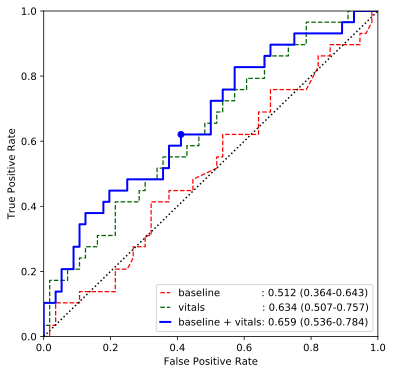

In [110]:
fig, ax = plt.subplots(figsize=(6,6))
for i, (name, output, color, linestyle) in enumerate([
    (r'baseline             ', results_baseline, 'red', '--'), 
    (r'vitals                  ', results_vitals, 'darkgreen', '--'),
    (r'baseline + vitals', results_main, 'blue', '-'),
]):
    _, _, fpr, tpr, roc_curves, auc_scores, mean_fpr, mean_tpr, tprs_lower, tprs_upper = output
    auc_scores = np.array(auc_scores)
    idx_lower = abs(auc_scores - np.percentile(auc_scores, 2.5)).argmin()
    idx_upper = abs(auc_scores - np.percentile(auc_scores, 97.5)).argmin()
    lower = scipy.interp(mean_fpr, roc_curves[idx_lower][0], roc_curves[idx_lower][1])
    upper = scipy.interp(mean_fpr, roc_curves[idx_upper][0], roc_curves[idx_upper][1])
    
    plt.plot(
        fpr, tpr, color=color, lw=1.25 * [1, 1, 1.6][i], ls=linestyle,
        label='{}: {:.3f} ({:.3f}-{:.3f})'.format(
            name, metrics.auc(fpr, tpr),
            np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5),
        )
    )

threshold_p = 55
threshold = np.percentile(clf.predict_proba(Xtr)[:,1], threshold_p)
y_prob = clf.predict_proba(Xte)[:,1]
y_pred = (y_prob > threshold)
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob)

tpr_ = metrics.recall_score(y_true, y_pred)
idx = (np.abs(tpr - tpr_)).argmin()

plt.plot([fpr[idx]], [tpr[idx]], marker='o', markersize=6, color="blue")

leg = plt.legend(loc='lower right', handlelength=1)
leg._legend_box.align = "right"
plt.plot([0,1], [0,1], 'k:')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim(0,1)
plt.ylim(0,1)

plt.savefig('fig/ROC_curves.pdf', bbox_inches='tight')
plt.savefig('fig/ROC_curves.svg', bbox_inches='tight')
plt.show()